In [61]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')
files = os.listdir('data')
df = np.empty([0, 8])
for file in files:
    if "publ_2017" not in file: continue
    #arr = np.genfromtxt('data/'+file, delimiter="','")
    arr = pd.read_csv('data/'+file, delimiter="','", engine='python')
    #if arr.shape[0] == 0: continue
    df = np.concatenate((df, arr))
    break
df = pd.DataFrame(df, columns=['publ_year', 'publ_month', 'publ_day', 'decision_date', 'number', 'subject', 'subject_desc', 'content'])
len(df)

693

In [80]:
def transform(x):
    #x['publ_year'] = int(x['publ_year'].replace("'", ""))
    x['dec_day'], x['dec_month'], x['dec_year'] = x['decision_date'].split('.')
    x['content_len'] = len(x['content'])

    # Get references
    # Doesnt work with § or eg "Art. 40 Abs. 1 des Bundesgerichtsreglements"
    reg = r'Art\. \d+ (?:[A-Za-z\.]{0,5} \d{1}\d?)?(?:[ A-Z]{0,5})?'
    x['ref_articles'] = re.findall(reg, x['content'])
    x['ref_articles_len'] = len(x['ref_articles'])
    # for BGE ...
    reg = r'\d{0,3} [IV]{1,3} \d{0,3} E'
    x['ref_bge'] = re.findall(reg, x['content'])
    x['ref_bge_len'] = len(x['ref_bge'])
    # for 1C_573/2016 ...
    reg = r'\d[A-Z]_\d{3}\/\d{4}'
    x['ref_publ'] = re.findall(reg, x['content'])
    x['ref_publ_len'] = len(x['ref_publ'])
    return x

df = df.apply(transform, axis=1)

# Type casting, for performance
conv = df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
df[conv.columns] = conv

conv = df.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
df[conv.columns] = conv
del conv

df.head(3)

#df.dtypes

# Hole Referenzen (BGE, Artikel) aus den BGE
# Score Referenzen
# Darstellen

,publ_year,publ_month,publ_day,decision_date,number,subject,subject_desc,content,dec_day,dec_month,dec_year,content_len,ref_articles,ref_articles_len,ref_bge,ref_bge_len,ref_publ,ref_publ_len
0,'2017,7,3,29.05.2017,2C_1153/2016,Gesundheitswesen & soziale Sicherheit,"Bronchialpastillen, Verlängerung der Zulassung...",\n \n\xa0\nBundesgericht\xa0\nTribunal f\...,29,05,2017,21835,"[Art. 84 Abs. 1 , Art. 82 , Art. 86 Abs. 1 , A...",48,"[139 I 229 E, 134 II 244 E, 137 I 58 E, 136 II...",7,"[2C_769/2015, 2C_769/2015, 2C_769/2015, 2C_769...",8
1,'2017,7,3,02.06.2017,2C_68/2016,Finances publiques & droit fiscal,Impôt de succession,\n \n\xa0\nBundesgericht\xa0\nTribunal f\...,02,06,2017,29130,[],0,[],0,"[2C_164/2015, 2C_242/2014, 1C_279/2016, 2C_744...",4
2,'2017,7,3,06.06.2017,9C_46/2017,Invalidenversicherung,Invalidenversicherung,\n \n\xa0\nBundesgericht\xa0\nTribunal f\...,06,06,2017,17454,"[Art. 13 Abs. 1 , Art. 14 Abs. 1 , Art. 90 BGG...",18,[140 V 282 E],1,"[9C_299/2016, 9C_299/2016]",2


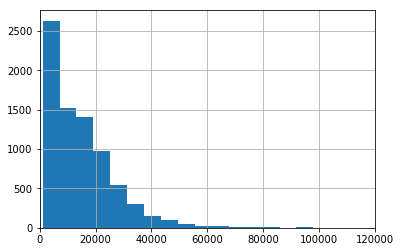

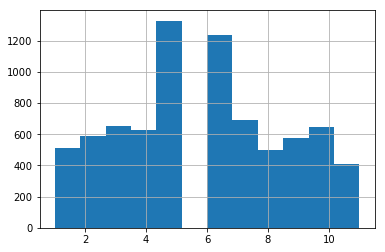

In [77]:
df['content_len'].hist(bins=50)
plt.xlim([0, 120000])
plt.show()

df['publ_month'].hist(bins=12)
plt.show()

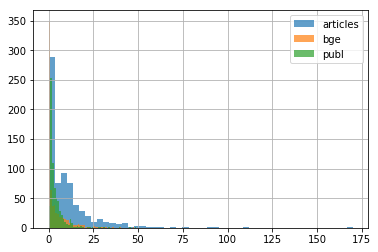

In [25]:
df['ref_articles_len'].hist(bins=50, alpha=0.7, label='articles')
df['ref_bge_len'].hist(bins=50, alpha=0.7, label='bge')
df['ref_publ_len'].hist(bins=50, alpha=0.7, label='publ')
plt.legend()
plt.show()

In [90]:
# df[df['ref_publ_len'] < 3].iloc[0]['content']
import networkx as nx
from networkx.readwrite import json_graph
import json
G = nx.Graph()
i = 0
for x in df.iterrows():
    for ref_publ in x[1]['ref_publ']:
        G.add_edge(str(x[1]['number']), str(ref_publ))
        i += 1
    if i > 30:
        break
    
data = json_graph.node_link_data(G)
json.dump(data, open('graph.json','w'))
#nx.spring_layout(G)
#nx.draw(G, with_labels = True)
#plt.show()